<a href="https://colab.research.google.com/github/lijingwang/hbvpy/blob/main/HBV_uncertainty_propagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/lijingwang/hbvpy.git
%cd hbvpy

# Uncertainty Propagation in HBV Model
## Monte Carlo Sampling vs Latin Hypercube Sampling

This notebook demonstrates uncertainty propagation techniques for the HBV hydrological model:
1. **Monte Carlo (MC) Sampling**: Random sampling from parameter distributions
2. **Latin Hypercube Sampling (LHS)**: Stratified sampling that ensures better coverage of parameter space

We will:
- Define probability distributions for all 10 HBV parameters
- Generate parameter samples using both methods
- Run the HBV model for each parameter set
- Calculate and visualize the 95% prediction intervals
- Compare how sample size affects uncertainty estimates

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import qmc
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

from hbv import hbv_run

## 1. Load Input Data

In [2]:
example_dir = Path("examples") / "Prof_Amir_AghaKouchak_example"

forcing = pd.read_csv(example_dir / "inputPrecipTemp.csv", parse_dates=["Time"])
forcing["Time"] = pd.to_datetime(forcing["Time"], format="%Y-%m-%d")
pet = pd.read_csv(example_dir / "inputMonthlyTempEvap.csv")
Qobs = pd.read_csv(example_dir / "Qobs.csv", parse_dates=["Time"])
Qobs["Time"] = pd.to_datetime(Qobs["Time"], format="%Y-%m-%d")

print(f"Simulation period: {forcing['Time'].min()} to {forcing['Time'].max()}")
print(f"Number of days: {len(forcing)}")

Simulation period: 1991-01-01 00:00:00 to 2000-12-30 00:00:00
Number of days: 3652


## 2. Define Parameter Distributions

We assume **uniform distributions** for all 10 HBV parameters. Uniform distributions are commonly used when we have limited prior knowledge about parameters but know their plausible ranges.

| Parameter | Description | Min | Max | Unit |
|-----------|-------------|-----|-----|------|
| d | Degree-day melt factor | 1.0 | 5.0 | mm/°C/day |
| fc | Field capacity | 100 | 400 | mm |
| beta | Runoff nonlinearity exponent | 1.0 | 5.0 | - |
| cpar | PET temperature correction | 0.01 | 0.3 | - |
| k0 | Quickflow coefficient | 0.1 | 0.5 | 1/day |
| lthr | Upper storage threshold | 1.0 | 20.0 | mm |
| k1 | Interflow coefficient | 0.01 | 0.2 | 1/day |
| k2 | Baseflow coefficient | 0.005 | 0.15 | 1/day |
| kp | Percolation coefficient | 0.01 | 0.15 | 1/day |
| pwp | Permanent wilting point | 50 | 200 | mm |

In [3]:
# Parameter names and their distributions (min, max for uniform)
param_names = ["d", "fc", "beta", "cpar", "k0", "lthr", "k1", "k2", "kp", "pwp"]

param_bounds = {
    "d":    (1.0, 5.0),      # degree-day melt factor (mm/degC/day)
    "fc":   (100.0, 400.0),  # field capacity (mm)
    "beta": (1.0, 5.0),      # runoff nonlinearity exponent
    "cpar": (0.01, 0.3),     # PET temperature correction factor
    "k0":   (0.1, 0.5),      # quickflow coefficient (1/day)
    "lthr": (1.0, 20.0),     # threshold in upper storage (mm)
    "k1":   (0.01, 0.2),     # interflow coefficient (1/day)
    "k2":   (0.005, 0.15),   # baseflow coefficient (1/day)
    "kp":   (0.01, 0.15),    # percolation coefficient (1/day)
    "pwp":  (50.0, 200.0),   # permanent wilting point (mm)
}

# Extract lower and upper bounds as arrays
lower_bounds = np.array([param_bounds[p][0] for p in param_names])
upper_bounds = np.array([param_bounds[p][1] for p in param_names])

n_params = len(param_names)
print(f"Number of parameters: {n_params}")

Number of parameters: 10


## 3. Sampling Methods

### 3.1 Monte Carlo (MC) Sampling
Random sampling from uniform distributions - simple but may have clustering/gaps in parameter space.

### 3.2 Latin Hypercube Sampling (LHS)
Stratified sampling that divides each parameter range into N equal intervals and ensures one sample from each interval. This provides better coverage of the parameter space with fewer samples.

In [4]:
def monte_carlo_sampling(n_samples, lower, upper, seed=42):
    """
    Generate parameter samples using Monte Carlo (random) sampling.
    
    Parameters
    ----------
    n_samples : int
        Number of samples to generate
    lower : array-like
        Lower bounds for each parameter
    upper : array-like
        Upper bounds for each parameter
    seed : int
        Random seed for reproducibility
    
    Returns
    -------
    samples : ndarray, shape (n_samples, n_params)
        Parameter samples
    """
    np.random.seed(seed)
    n_params = len(lower)
    samples = np.zeros((n_samples, n_params))
    
    for i in range(n_params):
        samples[:, i] = np.random.uniform(lower[i], upper[i], n_samples)
    
    return samples


def latin_hypercube_sampling(n_samples, lower, upper, seed=42):
    """
    Generate parameter samples using Latin Hypercube Sampling (LHS).
    
    Parameters
    ----------
    n_samples : int
        Number of samples to generate
    lower : array-like
        Lower bounds for each parameter
    upper : array-like
        Upper bounds for each parameter
    seed : int
        Random seed for reproducibility
    
    Returns
    -------
    samples : ndarray, shape (n_samples, n_params)
        Parameter samples
    """
    n_params = len(lower)
    
    # Create LHS sampler using scipy.stats.qmc
    sampler = qmc.LatinHypercube(d=n_params, seed=seed)
    
    # Generate samples in [0, 1] hypercube
    unit_samples = sampler.random(n=n_samples)
    
    # Scale to parameter bounds
    samples = qmc.scale(unit_samples, lower, upper)
    
    return samples

In [5]:
# Number of samples for uncertainty propagation
N_SAMPLES = 500

# Generate samples using both methods
mc_samples = monte_carlo_sampling(N_SAMPLES, lower_bounds, upper_bounds, seed=42)
lhs_samples = latin_hypercube_sampling(N_SAMPLES, lower_bounds, upper_bounds, seed=42)

print(f"Monte Carlo samples shape: {mc_samples.shape}")
print(f"Latin Hypercube samples shape: {lhs_samples.shape}")

Monte Carlo samples shape: (500, 10)
Latin Hypercube samples shape: (500, 10)


### Visualize Sampling Differences
Let's compare the two sampling methods for the first two parameters to see how LHS provides better coverage.

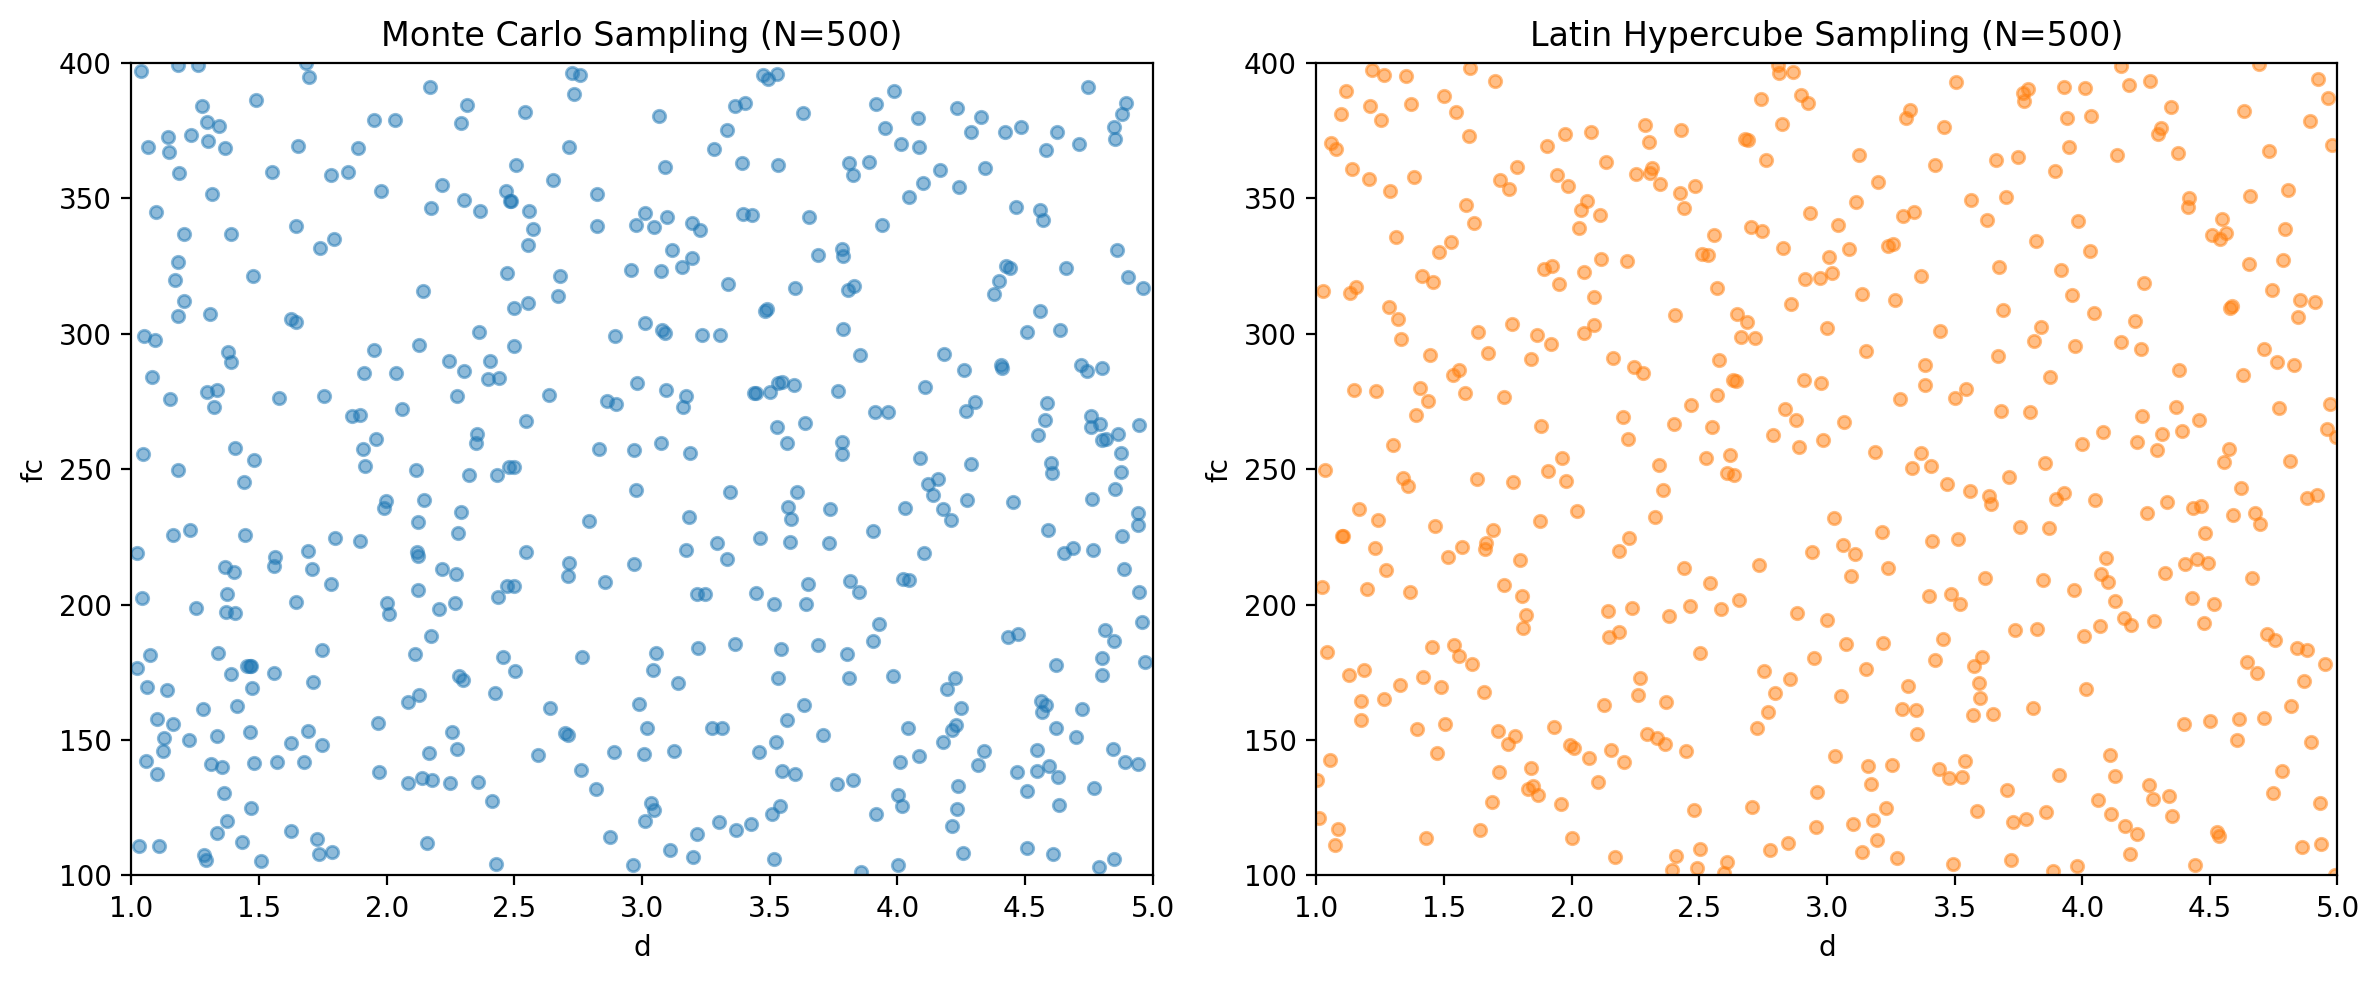

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot first two parameters
p1, p2 = 0, 1  # d and fc

n = 500
axes[0].scatter(mc_samples[:n, p1], mc_samples[:n, p2], alpha=0.5, s=20)
axes[0].set_xlabel(f"{param_names[p1]}")
axes[0].set_ylabel(f"{param_names[p2]}")
axes[0].set_title(f"Monte Carlo Sampling (N={N_SAMPLES})")
axes[0].set_xlim(lower_bounds[p1], upper_bounds[p1])
axes[0].set_ylim(lower_bounds[p2], upper_bounds[p2])

axes[1].scatter(lhs_samples[:n, p1], lhs_samples[:n, p2], alpha=0.5, s=20, c='C1')
axes[1].set_xlabel(f"{param_names[p1]}")
axes[1].set_ylabel(f"{param_names[p2]}")
axes[1].set_title(f"Latin Hypercube Sampling (N={N_SAMPLES})")
axes[1].set_xlim(lower_bounds[p1], upper_bounds[p1])
axes[1].set_ylim(lower_bounds[p2], upper_bounds[p2])

plt.tight_layout()
plt.show()

## 4. Run HBV Model with Sampled Parameters

Now we run the HBV model for each parameter set from both sampling methods.

In [7]:
def run_ensemble(samples, forcing, pet, area_km2=410.0, verbose=True):
    """
    Run HBV model for an ensemble of parameter samples.
    
    Parameters
    ----------
    samples : ndarray, shape (n_samples, n_params)
        Parameter samples
    forcing : DataFrame
        Forcing data (precipitation, temperature)
    pet : DataFrame
        Monthly PET data
    area_km2 : float
        Catchment area in km^2
    verbose : bool
        Print progress updates
    
    Returns
    -------
    Q_ensemble : ndarray, shape (n_samples, n_days)
        Discharge time series for each parameter set
    time : array
        Time array
    """
    n_samples = samples.shape[0]
    n_days = len(forcing)
    Q_ensemble = np.zeros((n_samples, n_days))
    
    for i in range(n_samples):
        if verbose and (i + 1) % 100 == 0:
            print(f"  Running simulation {i+1}/{n_samples}")
        
        params = samples[i, :]
        results, _ = hbv_run(
            forcing=forcing,
            pet_monthly=pet,
            params=params,
            area_km2=area_km2,
            Tsnow_thresh=0.0,
            init_state={"snow": 0.0, "soil": 0.0, "s1": 0.0, "s2": 0.0},
        )
        Q_ensemble[i, :] = results["Q_m3s"].values
    
    time = results["Time"].values
    return Q_ensemble, time

In [8]:
print("Running Monte Carlo ensemble...")
Q_mc, time = run_ensemble(mc_samples, forcing, pet)
time_index = pd.DatetimeIndex(time)

print("\nRunning Latin Hypercube ensemble...")
Q_lhs, _ = run_ensemble(lhs_samples, forcing, pet)

print(f"\nEnsemble output shape: {Q_mc.shape} (samples x days)")

Running Monte Carlo ensemble...
  Running simulation 100/500
  Running simulation 200/500
  Running simulation 300/500
  Running simulation 400/500
  Running simulation 500/500

Running Latin Hypercube ensemble...
  Running simulation 100/500
  Running simulation 200/500
  Running simulation 300/500
  Running simulation 400/500
  Running simulation 500/500

Ensemble output shape: (500, 3652) (samples x days)


## 5. Calculate Prediction Intervals

We calculate the **95% prediction interval** as the range between the 2.5th and 97.5th percentiles of the ensemble at each time step.

In [9]:
def calculate_prediction_intervals(Q_ensemble, percentiles=[2.5, 50, 97.5]):
    """
    Calculate prediction intervals from ensemble.
    
    Parameters
    ----------
    Q_ensemble : ndarray, shape (n_samples, n_days)
        Ensemble of discharge time series
    percentiles : list
        Percentiles to calculate (default: 2.5, 50, 97.5 for 95% CI)
    
    Returns
    -------
    results : dict
        Dictionary with percentile arrays
    """
    results = {}
    for p in percentiles:
        results[f"p{p}"] = np.percentile(Q_ensemble, p, axis=0)
    results["mean"] = np.mean(Q_ensemble, axis=0)
    results["std"] = np.std(Q_ensemble, axis=0)
    return results

In [10]:
# Calculate prediction intervals for both methods
mc_stats = calculate_prediction_intervals(Q_mc)
lhs_stats = calculate_prediction_intervals(Q_lhs)

print("Statistics calculated for both ensembles.")

Statistics calculated for both ensembles.


In [11]:
def report_pi(date_str, label, stats):
    idx = time_index.get_loc(pd.Timestamp(date_str))
    lo  = stats["p2.5"][idx]
    hi  = stats["p97.5"][idx]
    med = stats["p50"][idx]
    print(f"{label} ({date_str})")
    print(f"  2.5th percentile : {lo:.3f} m³/s")
    print(f"  Median           : {med:.3f} m³/s")
    print(f"  97.5th percentile: {hi:.3f} m³/s")
    print(f"  95% PI width     : {hi - lo:.3f} m³/s")
    print()

print("LHS ensemble (N=500) — 95% Prediction Intervals")
print("=" * 50)
DATE_  = "1994-10-01"
report_pi(DATE_, "Baseflow date", lhs_stats)

LHS ensemble (N=500) — 95% Prediction Intervals
Baseflow date (1994-10-01)
  2.5th percentile : 0.018 m³/s
  Median           : 0.692 m³/s
  97.5th percentile: 3.399 m³/s
  95% PI width     : 3.380 m³/s



## 6. Plot 95% Prediction Intervals

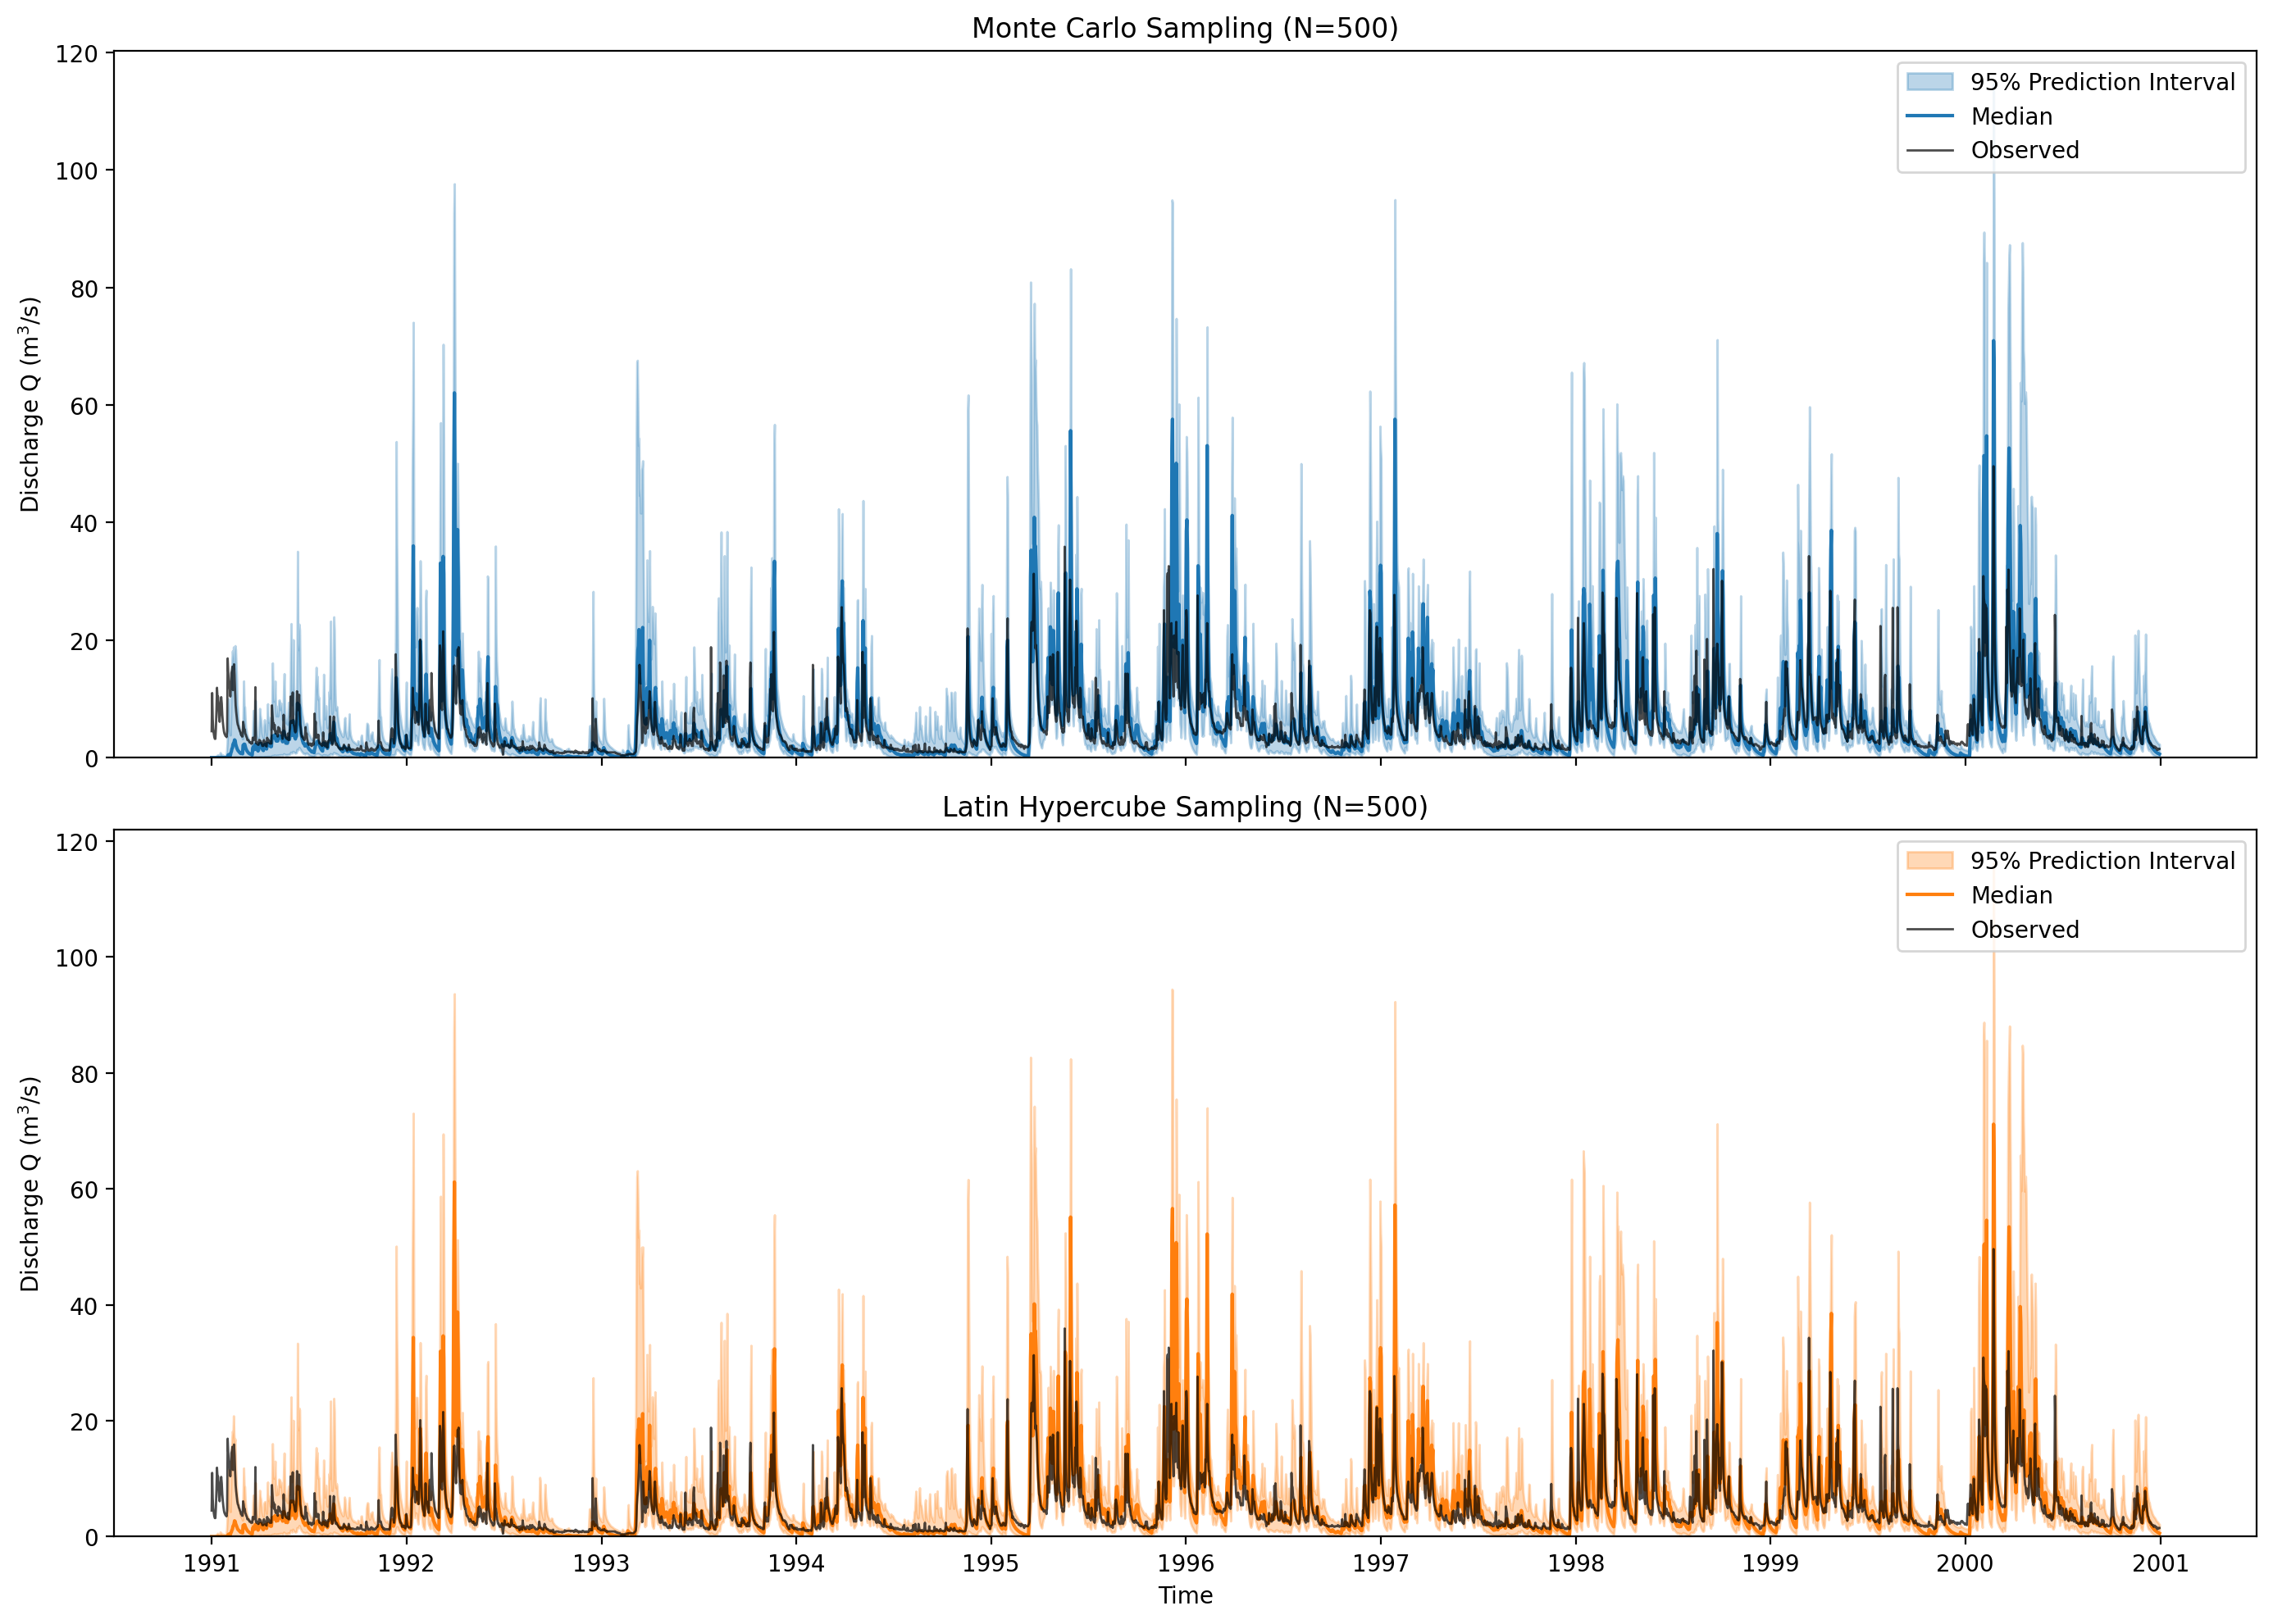

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Monte Carlo results
ax = axes[0]
ax.fill_between(time, mc_stats["p2.5"], mc_stats["p97.5"], 
                alpha=0.3, color='C0', label='95% Prediction Interval')
ax.plot(time, mc_stats["p50"], 'C0-', lw=1.5, label='Median')
ax.plot(Qobs["Time"], Qobs["Q (m3/s)"], 'k-', lw=1, alpha=0.7, label='Observed')
ax.set_ylabel("Discharge Q (m$^3$/s)")
ax.set_title(f"Monte Carlo Sampling (N={N_SAMPLES})")
ax.legend(loc='upper right')
ax.set_ylim(bottom=0)

# Latin Hypercube results
ax = axes[1]
ax.fill_between(time, lhs_stats["p2.5"], lhs_stats["p97.5"], 
                alpha=0.3, color='C1', label='95% Prediction Interval')
ax.plot(time, lhs_stats["p50"], 'C1-', lw=1.5, label='Median')
ax.plot(Qobs["Time"], Qobs["Q (m3/s)"], 'k-', lw=1, alpha=0.7, label='Observed')
ax.set_xlabel("Time")
ax.set_ylabel("Discharge Q (m$^3$/s)")
ax.set_title(f"Latin Hypercube Sampling (N={N_SAMPLES})")
ax.legend(loc='upper right')
ax.set_ylim(bottom=0)
plt.tight_layout()
plt.show()

## 7. Summary Statistics for N=500

In [13]:
# Calculate interval width (uncertainty)
mc_interval_width = mc_stats["p97.5"] - mc_stats["p2.5"]
lhs_interval_width = lhs_stats["p97.5"] - lhs_stats["p2.5"]

print("=" * 60)
print("UNCERTAINTY PROPAGATION SUMMARY (N=500)")
print("=" * 60)
print(f"Number of samples: {N_SAMPLES}")
print(f"Number of parameters: {n_params}")
print(f"Simulation period: {len(time)} days")
print()
print("Monte Carlo Sampling:")
print(f"  Mean 95% PI width: {np.mean(mc_interval_width):.2f} m3/s")
print(f"  Max 95% PI width:  {np.max(mc_interval_width):.2f} m3/s")
print(f"  Mean discharge:    {np.mean(mc_stats['mean']):.2f} m3/s")
print()
print("Latin Hypercube Sampling:")
print(f"  Mean 95% PI width: {np.mean(lhs_interval_width):.2f} m3/s")
print(f"  Max 95% PI width:  {np.max(lhs_interval_width):.2f} m3/s")
print(f"  Mean discharge:    {np.mean(lhs_stats['mean']):.2f} m3/s")
print("=" * 60)

UNCERTAINTY PROPAGATION SUMMARY (N=500)
Number of samples: 500
Number of parameters: 10
Simulation period: 3652 days

Monte Carlo Sampling:
  Mean 95% PI width: 9.30 m3/s
  Max 95% PI width:  82.84 m3/s
  Mean discharge:    6.16 m3/s

Latin Hypercube Sampling:
  Mean 95% PI width: 9.26 m3/s
  Max 95% PI width:  82.12 m3/s
  Mean discharge:    6.14 m3/s


## 8. Effect of Sample Size on Uncertainty Estimates

An important question in uncertainty analysis is: **How many samples do we need?**

Since we already have 500 samples, we can simply take subsets (first N samples) to see how statistics change with sample size.

This demonstrates:
1. How prediction interval estimates converge with more samples
2. The advantage of LHS over MC at small sample sizes

In [14]:
# Sample sizes to compare (using subsets of existing 500 samples)
sample_sizes = [500, 100, 50, 20, 10]

# Store results for each sample size
results_by_size = {}

for n in sample_sizes:
    # Use first n samples from the already computed ensembles
    Q_mc_n = Q_mc[:n, :]
    Q_lhs_n = Q_lhs[:n, :]
    
    # Calculate statistics
    mc_stats_n = calculate_prediction_intervals(Q_mc_n)
    lhs_stats_n = calculate_prediction_intervals(Q_lhs_n)
    
    # Store results
    results_by_size[n] = {
        'mc': {
            'stats': mc_stats_n,
            'mean_pi_width': np.mean(mc_stats_n["p97.5"] - mc_stats_n["p2.5"]),
            'max_pi_width': np.max(mc_stats_n["p97.5"] - mc_stats_n["p2.5"]),
            'mean_discharge': np.mean(mc_stats_n['mean']),
        },
        'lhs': {
            'stats': lhs_stats_n,
            'mean_pi_width': np.mean(lhs_stats_n["p97.5"] - lhs_stats_n["p2.5"]),
            'max_pi_width': np.max(lhs_stats_n["p97.5"] - lhs_stats_n["p2.5"]),
            'mean_discharge': np.mean(lhs_stats_n['mean']),
        }
    }

print("Statistics calculated for sample sizes:", sample_sizes)

Statistics calculated for sample sizes: [500, 100, 50, 20, 10]


### Summary Statistics Table: Effect of Sample Size

In [15]:
# Create summary table
print("\n" + "="*90)
print("SUMMARY STATISTICS BY SAMPLE SIZE")
print("="*90)
print(f"{'N':>6} | {'Method':>6} | {'Mean 95% PI Width':>18} | {'Max 95% PI Width':>17} | {'Mean Q':>10}")
print("-"*90)

for n in sample_sizes:
    mc_res = results_by_size[n]['mc']
    lhs_res = results_by_size[n]['lhs']
    
    print(f"{n:>6} | {'MC':>6} | {mc_res['mean_pi_width']:>15.2f} m3/s | {mc_res['max_pi_width']:>14.2f} m3/s | {mc_res['mean_discharge']:>7.2f} m3/s")
    print(f"{n:>6} | {'LHS':>6} | {lhs_res['mean_pi_width']:>15.2f} m3/s | {lhs_res['max_pi_width']:>14.2f} m3/s | {lhs_res['mean_discharge']:>7.2f} m3/s")
    print("-"*90)

print("="*90)


SUMMARY STATISTICS BY SAMPLE SIZE
     N | Method |  Mean 95% PI Width |  Max 95% PI Width |     Mean Q
------------------------------------------------------------------------------------------
   500 |     MC |            9.30 m3/s |          82.84 m3/s |    6.16 m3/s
   500 |    LHS |            9.26 m3/s |          82.12 m3/s |    6.14 m3/s
------------------------------------------------------------------------------------------
   100 |     MC |            8.43 m3/s |          86.17 m3/s |    6.01 m3/s
   100 |    LHS |            9.04 m3/s |          81.70 m3/s |    6.18 m3/s
------------------------------------------------------------------------------------------
    50 |     MC |            7.75 m3/s |          89.74 m3/s |    5.78 m3/s
    50 |    LHS |            8.87 m3/s |          83.88 m3/s |    6.21 m3/s
------------------------------------------------------------------------------------------
    20 |     MC |            7.08 m3/s |          78.80 m3/s |    5.82 m3/s

### Visualization: How Sample Size Affects Uncertainty Estimates

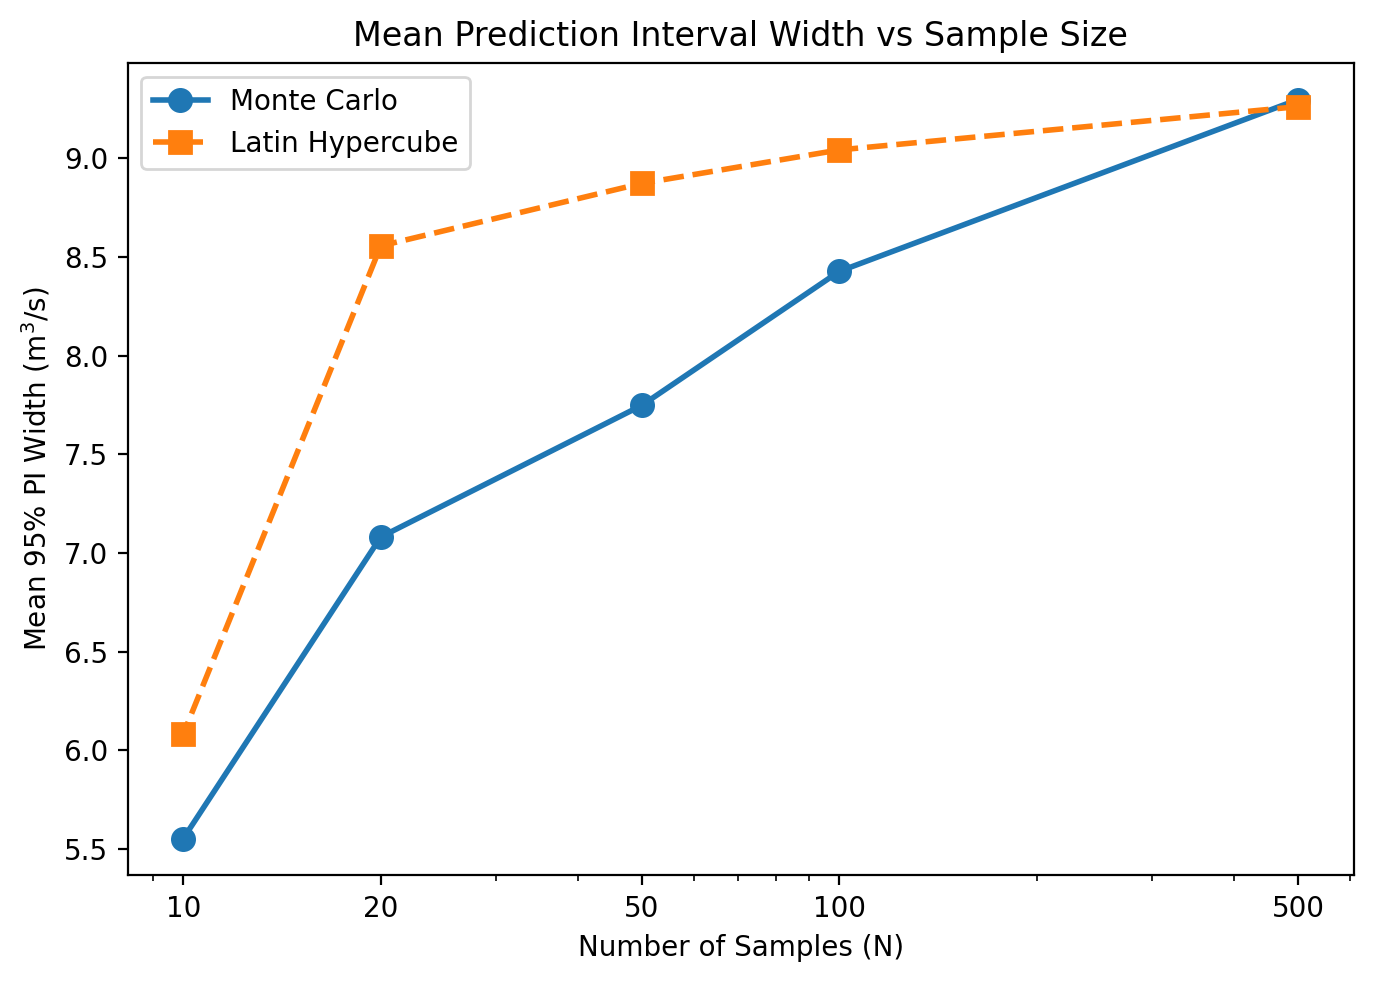

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5))

# Extract data for plotting
mc_mean_pi = [results_by_size[n]['mc']['mean_pi_width'] for n in sample_sizes]
lhs_mean_pi = [results_by_size[n]['lhs']['mean_pi_width'] for n in sample_sizes]
mc_max_pi = [results_by_size[n]['mc']['max_pi_width'] for n in sample_sizes]
lhs_max_pi = [results_by_size[n]['lhs']['max_pi_width'] for n in sample_sizes]

# Plot Mean 95% PI Width
ax = axes
ax.plot(sample_sizes, mc_mean_pi, 'o-', color='C0', lw=2, markersize=8, label='Monte Carlo')
ax.plot(sample_sizes, lhs_mean_pi, 's--', color='C1', lw=2, markersize=8, label='Latin Hypercube')
ax.set_xlabel('Number of Samples (N)')
ax.set_ylabel('Mean 95% PI Width (m$^3$/s)')
ax.set_title('Mean Prediction Interval Width vs Sample Size')
ax.legend()
ax.set_xscale('log')
ax.set_xticks(sample_sizes)
ax.set_xticklabels(sample_sizes)

plt.tight_layout()
plt.show()